## 주제선정이유
주식차트를 보던 중 비슷한 정도의 호재에도 어떤기업은 주가가 많이 그리고 지속적으로 오르는데 어떤 기업은 그렇지 못한 모습을 보였다. 위 두 기업은 거래량에서 명확한 차이가 났다. 그렇기에 나는 주가의 상승폭이 거래량과 관련이 있지 않을까 라는 의문을 가지게 되었고 이를 확인해보자 하였다. 또한 추가적으로 기업의 가치평가를 할때 자주 사용되는 재무제표가 정말 주가와 연관성이 있는지 확인해보았다.


## 가설 1. 주가 상승 하락폭이 큰 날이 아닌날 보다 거래량이 더 많을 것이다.

## 가설2. 기본적 분석에 활용되는 재무제표는 기업의 거래량과 관련이 있을 것이다. 

# 데이터들
#### 유한양행의 거래정보 데이터 (_000100.volume.csv)
#### 코스피 상장 기업의 재무제표 데이터(fs_df_2019.csv,fs_df_2020.csv)
####  코스피 상장 기업의 거래량 데이터(all_data_set.csv)
#### 공적분 페어 리스트(pairs.pickle)

웹 크롤링: csv파일, 코스피 상장기업 리스트


전처리 데이터: pickle(데이터량이 많아 따로 저장함)

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
from urllib import request as req
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from scipy import stats
%matplotlib inline
import copy
import statsmodels
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import power_transform

## 데이터 전처리
프로젝트를 진행하면서 전처리가 많이 필요했다. 왜도가 심한데이터, 이상치가 있는 데이터, 결측치등 분석을 함에 있어 방해되는 요소들이 하나한 줄여나갔다. 주로한 전처리는 스케일링, 로그변환, 거듭제곱 변환, 결측치 제거등이 있다. 전처리 내용이 많아 이후 전처리 시작부분에는 -전처리-, 끝부분에는 -end- 표시를 하겠다.
## 데이터 분석
전처리가 어느정도 완료된 데이터들로 데이터 분석을 진행하였다. 
분석을 위해 사용한 도구는 피어슨 상관관계이다. 
원 계획은 거래량은 피어슨 상관계수
재무제표는 클러스터링과 공적분으로 분석을 진행하려고 했다. 
하지만 재무제표 부분에서 클러스터링 보단 상관계수분석이 좀더 유의미 하다고 판단하여 피어슨 상관계수 그리고 공적분으로 둘의 관계를 분석해보았다. 

###  피어슨 상관계수
피어슨 상관계수는 데이터에서 두 변수의 공분산(covariance) 을 각각의 표준 편차의 곱으로 나눈 값이다.(위키피디아)
표준편차의 곱으로 나누었기 때문에 상관계수 값은 -1 ~ 1사이로 나오게 된다. 
여기서 주목해야할 점은 두 변수의 공분산이다. 
#### 공분산
공분산(共分散, 영어: covariance)은 2개의 확률변수의 선형 관계를 나타내는 값이다.[1] 만약 2개의 변수중 하나의 값이 상승하는 경향을 보일 때 다른 값도 상승하는 선형 상관성이 있다면 양수의 공분산을 가진다.[2] 반대로 2개의 변수중 하나의 값이 상승하는 경향을 보일 때 다른 값이 하강하는 선형 상관성을 보인다면 공분산의 값은 음수가 된다.(위키피디아)

공분산 식을 조금 들어다 보면, X의 편차와 Y의 편차를 곱하여 그것의 평균임을 알수있다. 여기서 핵심은 X이 편차와 Y의 편차를 곱한다는 것이다. 즉 X,Y의 값들이 평균에서 얼마나 멀어져있는가 그리고 편차가 양인가 음인가에 따라 공분산의 값이 결정된다. 
그럼으로 X,Y의 움직임에 대해 연관성을 찾아낼수 있다. 

## 1. 주가와 거래량이 관계가 있을까?

### 한 기업(유한양행)에 대해 거래량과 주가의 관계를 분석해보았다. 

크롤링으로 기업의 시장정보를 들고온다

In [2]:
df = pd.read_csv('_000100.volume.csv')

전일비에 +,-가 표시 돼지않았음으로 전일 가격과 비교하여 전일비에 +,- 를 부여한다

In [3]:
for i in df.index:
    if i != list(df.index)[-1]:
        if df.loc[i,'종가'] < df.loc[i+1,'종가']:
            df.loc[i,'전일비'] = - df.loc[i,'전일비']
        else:
            pass
    else:
        pass
    

주가의 상승폭을 확인하기 위해서 전일대비라는 컬럼을 만들었고 추가적으로 상승과 하락 두 상황에서 모두 적용가능하게 전일대비 값을 절댓값으로 만든 abs전일대비(%) 컬럼또한 만들었다. 



In [4]:
for i in df.index:
    if i != list(df.index)[-1]:
        df.loc[i,'전일대비(%)'] = round(float(df.loc[i,'전일비'])*100 / float(df.loc[i,'종가']),2)

df['abs전일대비(%)'] = abs(df['전일대비(%)'])

이상태로 상관관계 분석을 해보았다. 결과는 전일대비 그리고 abs전일대비 모두 거래량과 상관관계가 없다고 나온다

In [5]:
df.corr()

,종가,전일비,시가,고가,저가,거래량,전일대비(%),abs전일대비(%)
종가,1.000000,0.023753,0.997377,0.997711,0.997762,-0.094703,0.018095,-0.080880
전일비,0.023753,1.000000,-0.009896,0.008211,0.007259,0.060778,0.807555,0.030596
시가,0.997377,-0.009896,1.000000,0.999535,0.999537,-0.094388,-0.008790,-0.079668
고가,0.997711,0.008211,0.999535,1.000000,0.999340,-0.090031,0.005388,-0.069763
저가,0.997762,0.007259,0.999537,0.999340,1.000000,-0.096471,0.004425,-0.088282
거래량,-0.094703,0.060778,-0.094388,-0.090031,-0.096471,1.000000,0.113183,0.168515
전일대비(%),0.018095,0.807555,-0.008790,0.005388,0.004425,0.113183,1.000000,0.020975
abs전일대비(%),-0.080880,0.030596,-0.079668,-0.069763,-0.088282,0.168515,0.020975,1.000000


원인을 분석해보았다. 내가 찾은 원인은 크게 두가지이다. 
1. 분석한 기업은 몇년전에 액면분할을 했다. 보통 액면분할을 하면 주가가 내려가기때문에ㅣ이후 거래량이 증가한다.
2. 거래량은 시계열분석에 해당한다. 그럼으로 단순히 전일대비 값으로 비교하면 안된다.

1번 먼저 확인해보자 유한양행의 액면분할일은 2020년 4월8일이다. 크롤링해서 얻은 데이터의 앞부분은 계속해서 변함으로 뒤에서 부터 슬라잉싱을 진행한다. 

### 액면분할 일을 기준으로 슬라이싱한 테이블은 abs전일대비(%)와 거래량 사이에서 0.629 정도의 상관계수가 나왔다.
상관계수로 상관관계의 정도를 판단하는 기준은 아래와 같다. 0.8≤r 일 때, 강한 상관이 있다. 0.6≤r<0.8 일 때, 상관이 있다. 0.4≤r<0.6 일 때, 약한 상관이 있다라고 보기에 abs전일대비(%)와 거래량에서 서로 상관이 있다고 판단한다. 

In [6]:
df_1_1 = df.iloc[:-5969,:]
df_1_2 = df.iloc[-5969:,:]
#df_1_1: 액면분할 이후
#df_1_2: 액면분할 이전

In [7]:
print(df_1_1.corr().loc['거래량','abs전일대비(%)'],df_1_2.corr().loc['거래량','abs전일대비(%)'])

0.6308308576814534 0.2866132763283159


하지만 액면분할 이전의 상관계수는 매우낮게 나왔다. 이렇게 된다면 거래량과 abs전일대비 값이 상관성이 있다고 말할수 없다.
무언가 놓친게 있다고 판단하여 데이터들을 그래프로 그려보았다. 이때 공분산과 관련있는 평균값도 같이 본다.

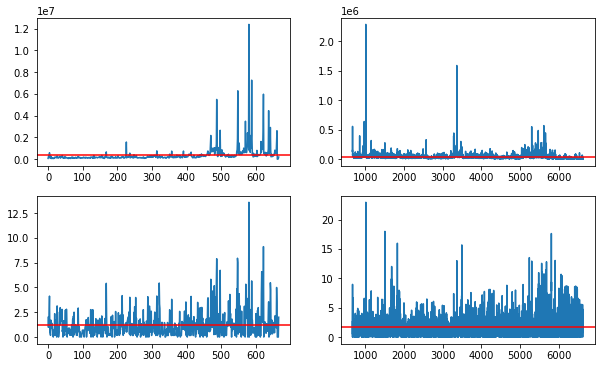

In [8]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(df_1_1['거래량'])
plt.axhline(y = df_1_1['거래량'].mean(),color = 'red')
plt.subplot(222)
plt.plot(df_1_2['거래량'])
plt.axhline(y = df_1_2['거래량'].mean(),color = 'red')
plt.subplot(223)
plt.plot(df_1_1['abs전일대비(%)'])
plt.axhline(y = df_1_1['abs전일대비(%)'].mean(),color = 'red')
plt.subplot(224)
plt.plot(df_1_2['abs전일대비(%)'])
plt.axhline(y = df_1_2['abs전일대비(%)'].mean(),color = 'red')
plt.show()


평균선을 한번보자 abs전일대비 그래프에 비해 거래량 그래프의 평균선이 매우 아래쪽에 위치해있는 것을 볼수있다. 
이는 전일대비는 단위가 % 이며 그 특성상 값의 변동성이 거래량만큼 크지 않기때문이다. 그럼으로 거래량데이터는 일부 이상치에 의해 피어슨 상관계수값이 크게 바뀔 것이다. 그럼으로 좀 더 정확한 분석을 위해 데이터 스케일링 필요하다. 

Scikit-Learn에서 제공하는 스케일러에는 크게 4가지가 존재한다.
1. StandardScaler
    기본스케일, 평균과 표준편차를 이용한다.
    평균을 제거하고 데이터 단위 분산으로 조정한다. 그러나 이상치가 존재한다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 확산은 매우 달라진다. (이상치에 민감하다)
2. MiniMaxScaler
    모든 feafure 값이 0~1사이에 있도록 데이터를 재조정한다. 다만 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다.(역시 이상치에 민감하다.)(데이터의 분포의 형태를 유지하면서 스케일링을 진행할 수 있다. 
3. MaxAbsScaler
    절댓값이 0~ 1사이에 매핑되도록 한다. 즉 -1~1 사이로 재조정한다. 양수 데이터로만 구성된 특징 데이터셋에서는 MiniMaxScaler와 유사하게 동작하며, 큰 이상치에 민감할 수 있다.
4. RobustScaler
    아웃라이어의 영향을 최소한 기법이다. 중앙값과 사분위수를 사용하기 때문에 StandardScaler와 비교해보면 표준화 후 동일한 값을 더 넓게 분포 시키고 있음을 확인 할 후 있다.

standardscaler를 사용해봤지만 이상치 때문에 분포가 정확하게 나오지않는다. 
이는 다른 scaler도 동일할것이다. 

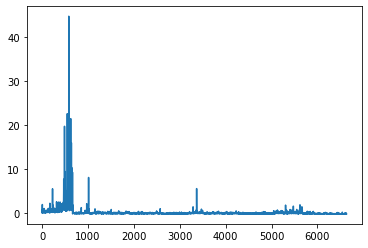

In [9]:
array_volum_000100 = df['거래량']
scaler = StandardScaler()
scaler.fit(array_volum_000100[:,np.newaxis])
_000100_scaler = scaler.transform(array_volum_000100[:,np.newaxis])
plt.plot(_000100_scaler)

스케일링이 의미가 없다는 것을 파악하고 로그변환을 시도해보았다


시계열에서 변환이 필요한 이유는 시간이 흐를수록 분산이 커지는 경우 그에 따른 ‘패널티’를 줘서 분산을 일정하게 하고 정상성을 얻기 위함이다. 루트나 로그 log 는 값이 클수록 줄어드는 양이 많기 때문에 자주 사용된다. https://freshrimpsushi.github.io/posts/transformation/

만약 거래량이 시계열분석에 해당하려면 시간이 지남에 따라 증가하는 추세에 있어야한다. 확인해보자

count    6.670000e+02
mean     4.016608e+05
std      7.834511e+05
min      0.000000e+00
25%      1.390075e+05
50%      2.012310e+05
75%      3.681500e+05
max      1.239500e+07
Name: 거래량, dtype: float64

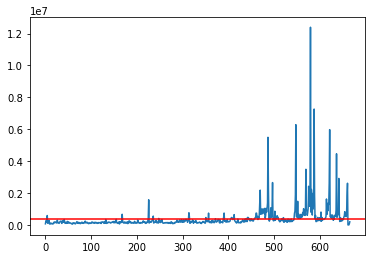

In [10]:
plt.plot(df_1_1['거래량'])
plt.axhline(y = df_1_1['거래량'].mean(),color = 'red')
#df_1_1은 액면분할 이후 
df_1_1.describe()['거래량']

count    5.969000e+03
mean     4.130992e+04
std      5.482404e+04
min      1.300000e+02
25%      1.931400e+04
50%      3.107600e+04
75%      4.965400e+04
max      2.285194e+06
Name: 거래량, dtype: float64

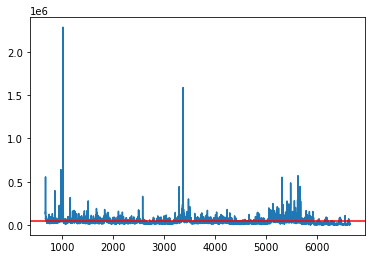

In [11]:
plt.plot(df_1_2['거래량'])
plt.axhline(y = df_1_2['거래량'].mean(),color = 'red')
#df_1_2는 액면분할 이전
df_1_2.describe()['거래량']

그렇다면 액면분할 이전과 이후에는 시간이 흐를수록 분산이 커진다. 이 말이 맞을까? 확인해보면 어느정도 그러한 경향성을 파악 할 수 있다. 25%,50%,75% 값들이 액면분할이후 값이 8~10배정도더 큰것을 알 수있다. 그럼으로 시계열 분석을 위해 로그변환을 해야한다. 

In [12]:
df_volum_log_1 = np.log(df_1_1['거래량'])
df_abs_log_1 = np.log(df_1_1['abs전일대비(%)'])
df_volum_log_2 = np.log(df_1_2['거래량'])
df_abs_log_2 = np.log(df_1_2['abs전일대비(%)'])

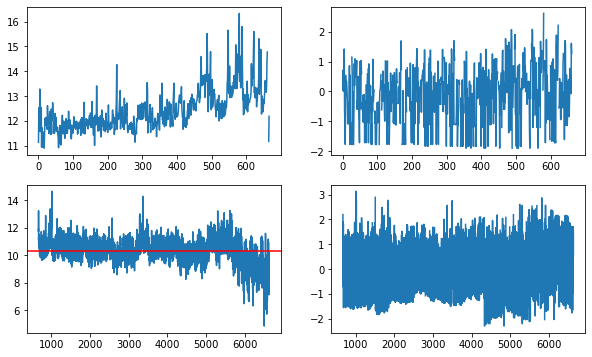

In [13]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(df_volum_log_1)
plt.axhline(y = df_volum_log_1.mean(),color = 'black')
plt.subplot(222)
plt.plot(df_abs_log_1)
plt.axhline(y = df_abs_log_1.mean(),color = 'red')
plt.subplot(223)
plt.plot(df_volum_log_2)
plt.axhline(y = df_volum_log_2.mean(),color = 'red')
plt.subplot(224)
plt.plot(df_abs_log_2)
plt.axhline(y = df_abs_log_2.mean(),color = 'red')

이제 다시 상관관계 분석을 다시 해보자

In [14]:
len(df_volum_log_1),len(df_abs_log_1)

(667, 667)

In [15]:
type(df_volum_log_1[0])

numpy.float64

In [16]:
df_abs_log_1[0]

0.03922071315328133

In [17]:
df_abs_log_1 = pd.DataFrame(df_abs_log_1)
df_volum_log_1 = pd.DataFrame(df_volum_log_1)
df_abs_volum_1 = pd.concat([df_abs_log_1,df_volum_log_1],axis = 1)
df_abs_volum_1.corr()

,abs전일대비(%),거래량
abs전일대비(%),1.000000,0.437871
거래량,0.437871,1.000000


In [18]:
df_abs_log_2 = pd.DataFrame(df_abs_log_2)
df_volum_log_2 = pd.DataFrame(df_volum_log_2)
df_abs_volum_2 = pd.concat([df_abs_log_2,df_volum_log_2],axis = 1)
df_abs_volum_2.corr()

,abs전일대비(%),거래량
abs전일대비(%),1.000000,0.159661
거래량,0.159661,1.000000


지금까지 유한양행 데이터로 실행을 했다면 이제는 전체 데이터로 분석을 해볼 생각이다.

## 1. 결론
## 주가랑 거래량은 특별한 상관관계가 없다. 
### -한계 -
### 이번분석에선 유한양행에 국한해서 분석하였기에 한계가 많다.
### 먼저 로그변환을 사용하면 0값이 결측치로 대체된다. 이는 abs컬럼에 치명적이다. 아마 많은량의 데이터가 결측치로 대체되었을 것이다.
### 또한 주식차트를 보면 주식이 높은 반등이나 하락을 

### 가지면 몇일동안 조정기간을 가진다. 또한 다른 여러경우에서 전일대비 값이 크지 않아도 거래량이 높은 경우가 있다.  
### 
### 즉  단순히 하루 하루 비교했다는 점에서 이번 분석은 한계를 가진다.
#### ---------------------------------------------------------------------------------------------------------------------------

# 2. 재무제표와 주가랑 어떠한 연관성이 있을까?
### 1) 투자에서 사용되는 pair trading 방법을 사용하여 연관된 두 기업을 찾는다.
### 2) 기업들의 재무제표가 서로 얼마나 연관성 있는지 확인한다
### 3) 2)에서 연관성이 높다고 나온 두 기업이 1)에서 연관된 두 기업에 해당할까? 
 ##### 먼저 재무제표가 연관성이 있다에 대해서 정의해야한다. 재무제표의 값들이 단순히 비슷하면 연관있는 재무제표일까? 조금만더 깊게 생각해보자 
1. 2019년도 유한양행(코드 000100) 재무제표가 있다고 가정해보자.뉴스를 통해 기업의 상황을 어느정돈 알 순 있어도 하나하나의 이벤트가 전체적인 기업에 어떠한 영향을 미치는지 실시간으로 알기 어렵다. 하지만 연말 재무제표를 보면 많은 이벤트들이 이 기업에 어떠한 영향을 미쳤는 가는 파악이 가능하다. 
2. 2019년도의 a기업의 재무제표와 2020년도의 a기업의 재무제표를 비교해보았을때 절대적인 값은 다를지언정 전체적인 상승과 하락이 비슷하다면 결국 재무제표 내의값들은 유기적으로 연결돼있다고 볼 수있을것이다.
(2) 는 추가적으로 확인할 예정

그럼으로 재무제표가 서로 연관성이 있는 기업이라면 두 기업의 재무제표 내의 값들이 비슷하게 움직일 것이다. 


먼저 코스피에 상장돼있는 기업들의 종목코드를 들고온다. 

In [19]:
def getStockCode(market):
    if market == 'kosdaq':
        url_market = 'kosdaqMkt'
    elif market == 'kospi':
        url_market = 'stockMkt'
    else:
        print('invalid market ')
        return
    url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13&marketType=%s' % url_market
    df_1 = pd.read_html(url, header=0)[0]
    return df_1

code_list에는 종목코드들이 int형으로 들어있다 그럼으로 종목코드 6자리(0이 앞에 있는경우)가 맞춰져있지 않는 경우가 있었다. 그렇기에 str형으로 바꿔주고 앞에 생략된 0을 추가해주었다. 

In [20]:
if __name__ == '__main__':
    result_df = getStockCode('kospi')
    result_df.to_csv('kospi.csv')
    
result_want = result_df[['회사명', '종목코드']]
result_want['종목코드']
code_list = list(result_want['종목코드'])
str_code_list = []
for k in code_list:
    str_code_list.append(str(k))
new_code_list = []
for i in str_code_list:
    x = '0'*(6 - len(i)) + i
    new_code_list.append(x)

이제 new_code_list에 있는 기업코드를 이용하여 네이버금융에 있는 기업의 재무제표 테이블을read_html로 들고온다. 
여러 년도가 있지만 먼저 2019년도것을 들고온다. 그리고 결측치가 많은 컬럼들을 삭제한 후 row를 기준으로 결측치가 있는 기업들을 삭제한다. 
여기서 결측치를 처리하는 방법중 삭제를 택한이유는 여러가지가 있다.
1. 
시가총액         798
상장주식수        798
ROE(%)       825
주당배당금        825
위 네가지 컬럼은 모두 결측치 비율이 너무 크기에 삭제를 했다.
2. 나머지 결측치들은 row를 기준으로 삭제를했다. 중앙값, 최빈값, 평균값으로 대체를 할까 생각을 했는데 결측치 나름의 이유가 있을것으로 판단하여 대체하지 않고 그냥 삭제하였다.

In [21]:
fs_df_2019 = pd.read_csv('fs_df_2019.csv')

In [22]:
fs_df_2019.index = new_code_list

In [23]:
fs_df_2019.isna().sum()

매출액           39
영업이익          38
당기순이익         38
영업이익률         39
순이익률          39
ROE(지배주주)     62
부채비율          38
당좌비율          85
유보율           38
EPS(원)        38
PER(배)        59
BPS(원)        38
PBR(배)        38
주당배당금(원)     102
시가배당률(%)     102
배당성향(%)       40
시가총액         798
상장주식수        798
ROE(%)       825
주당배당금        825
dtype: int64

In [24]:
fs_df_2019.drop(['시가총액','상장주식수','ROE(%)','주당배당금'],axis = 'columns',inplace = True)
fs_df_2019.dropna(inplace = True)

데이터 프레임안에 있는 값들이 숫자형이 아니기에 상관관계 분석을 할 수 없다. 그럼으로 astype으로 모두 숫자로 바꿀 생각이였지만 '-'이라는 문자형이 존재해 오류가 떴다. 그렇기에 '-'가 있는 컬럼과 row값을 뽑아봤다.

In [25]:
column_number = -1
column_list = []
row_list = []
for i in fs_df_2019.columns:
    
    row_number = -1
    column_number += 1
    for k in fs_df_2019[i]:
        #자꾸 float으로 변경할 수 없다고 나옴
        row_number += 1
        if type(k) == str:
            if '-' in k and len(k) == 1: 
                    column_list.append(column_number)
                    row_list.append(row_number)
                    print(column_number,row_number)


2 237
13 12
13 15
13 17
13 23
13 24
13 28
13 32
13 37
13 46
13 50
13 53
13 56
13 59
13 61
13 64
13 66
13 70
13 75
13 81
13 90
13 100
13 105
13 106
13 107
13 111
13 114
13 118
13 123
13 131
13 132
13 137
13 138
13 142
13 143
13 144
13 149
13 152
13 153
13 159
13 170
13 175
13 176
13 177
13 179
13 180
13 181
13 182
13 184
13 191
13 195
13 196
13 200
13 201
13 210
13 217
13 221
13 222
13 229
13 232
13 233
13 238
13 241
13 242
13 248
13 250
13 252
13 253
13 254
13 260
13 274
13 275
13 276
13 279
13 280
13 284
13 286
13 288
13 294
13 295
13 298
13 300
13 305
13 306
13 307
13 311
13 319
13 320
13 329
13 330
13 331
13 332
13 336
13 337
13 339
13 341
13 353
13 356
13 364
13 367
13 374
13 378
13 379
13 383
13 385
13 388
13 407
13 418
13 424
13 429
13 438
13 439
13 441
13 444
13 447
13 449
13 451
13 454
13 458
13 461
13 467
13 470
13 473
13 476
13 477
13 478
13 479
13 481
13 486
13 491
13 492
13 500
13 501
13 505
13 506
13 508
13 513
13 518
13 526
13 532
13 534
13 535
13 536
13 539
13 540
13 541

In [26]:
pd.DataFrame(column_list).value_counts()

13    174
14    174
15    173
2       1
dtype: int64

13,14,15컬럼에 '-' 즉 결측치가 추가로 존재했다. 개수는 174이다. 
row를 삭제하기에는 데이터 손실이 너무 많기에 차라리 13,14,15 컬럼을 삭제한다. 
그리고 기업코드 071090 row는 그냥 row를 삭제한다. 

마지막으로 astype으로 float형으로 바꿔준다. 

In [27]:
fs_df_2019.drop(['주당배당금(원)','시가배당률(%)','배당성향(%)'],axis = 1, inplace = True)

In [28]:
fs_df_2019.drop(index = '071090' ,axis = 0, inplace = True)

In [29]:
fs_df_2019 = fs_df_2019.astype(float)

In [30]:
fs_df_2019.T.corr()

,004840,155660,078930,294870,001390,025000,044450,058860,011070,037560,...,016450,010420,014130,005110,005440,010620,011210,011760,227840,010690
004840,1.000000,0.996447,0.613743,0.830441,0.866200,0.950220,0.988708,0.877975,0.868938,0.855555,...,0.421866,0.797755,0.858573,0.767741,0.696056,0.951531,0.929143,0.682696,0.954777,0.774137
155660,0.996447,1.000000,0.582584,0.819534,0.864521,0.972595,0.996962,0.856816,0.856339,0.836506,...,0.378782,0.772644,0.836311,0.743666,0.663052,0.950936,0.923551,0.654785,0.975419,0.744309
078930,0.613743,0.582584,1.000000,0.929860,0.868440,0.458537,0.532738,0.913671,0.912658,0.916192,...,0.964335,0.958407,0.926392,0.887711,0.989165,0.781737,0.834637,0.991184,0.471606,0.967841
294870,0.830441,0.819534,0.929860,1.000000,0.987246,0.742983,0.788937,0.980125,0.990938,0.969519,...,0.808425,0.976326,0.980633,0.900717,0.947588,0.943401,0.965581,0.952649,0.749828,0.965392
001390,0.866200,0.864521,0.868440,0.987246,1.000000,0.808402,0.840913,0.964711,0.977656,0.943733,...,0.728734,0.947607,0.962956,0.858837,0.898037,0.958068,0.969984,0.905850,0.810849,0.928656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
010620,0.951531,0.950936,0.781737,0.943401,0.958068,0.909984,0.933051,0.953029,0.968025,0.953590,...,0.605009,0.906891,0.941610,0.871969,0.831894,1.000000,0.995661,0.836188,0.917227,0.885429
011210,0.929143,0.923551,0.834637,0.965581,0.969984,0.867985,0.899543,0.974771,0.986643,0.975995,...,0.675920,0.941108,0.966801,0.900131,0.879277,0.995661,1.000000,0.883314,0.876491,0.923896
011760,0.682696,0.654785,0.991184,0.952649,0.905850,0.537346,0.605303,0.948335,0.946045,0.949863,...,0.941561,0.982955,0.959094,0.912235,0.996649,0.836188,0.883314,1.000000,0.549891,0.988124
227840,0.954777,0.975419,0.471606,0.749828,0.810849,0.999352,0.984374,0.765510,0.789367,0.761255,...,0.239738,0.671034,0.741060,0.662235,0.544964,0.917227,0.876491,0.549891,1.000000,0.633085


위 분석이 확실한지 확인하기 위해서 두 상관계수가 높은 두 기업의 그래프를 그려본다.

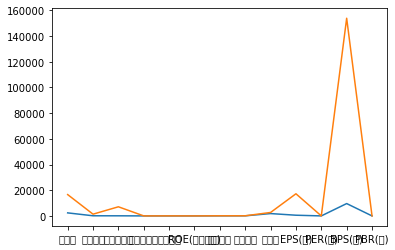

In [31]:
plt.plot(fs_df_2019.loc['155660',:])
plt.plot(fs_df_2019.loc['000210',:])

두 그래프를 비교해봤을때 비슷한 움직임을 보이는 것 같기도 하다. 하지만 상관계수가 0.97정도 까지인가? 싶다. 아마 그 원인은 이상치 때문인것 같다. 피어슨 상관계수 식을 보면 공분산이 있다. 즉 평균과 멀어질 수록 값이 증가한다. 이상치가 있음으로 나머지의 분포는 무시되고 이상치만이 비슷하면 비슷한 분포라고 계산한것이다. 


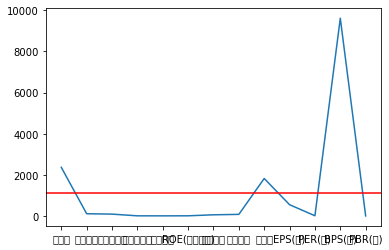

In [32]:
plt.plot(fs_df_2019.loc['155660',:])
plt.axhline(y = fs_df_2019.loc['155660',:].mean(),color = 'red')

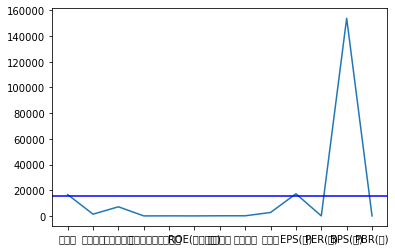

In [33]:
plt.plot(fs_df_2019.loc['000210',:])
plt.axhline(y = fs_df_2019.loc['000210',:].mean(),color = 'blue') 

그럼으로 정확하게 두 그래프를 비교하려면 데이터를 변환해야한다. 여기에서 가장 적절한 변환은 로그변환이다. 
이유는 이러하다. 
각각의 피처들의 값들은 각각의 의미를 가진다 즉 한 기업내에서의 위상은 의미가 없다. 그럼으로 위상의 영향을 극소화 시키는 log변환을 사용하였다. 이후 바로 로그변환을 사용해서 상관관계 분석을 진행해도 되지만 나는 먼저 

#### 2. 2019년도의 a기업의 재무제표와 2020년도의 a기업의 재무제표를 비교해보았을때 절대적인 값은 다를지언정 전체적인 상승과 하락이 비슷하다면 결국 재무제표 안의값들은 유기적으로 연결돼있다고 볼 수있을것이다.

#### 위 내용을 증명하고 시작할 것이다.

In [34]:
new_df_2_2 = pd.DataFrame()
list_0 = []
for code in new_code_list:
    try:
        URL = f"https://finance.naver.com/item/main.nhn?code={code}"
        r = requests.get(URL)
        df_1_2 = pd.read_html(r.text)[3]
        df_1_2.set_index(df_1_2.columns[0],inplace=True)
        df_1_2.index.rename('주요재무정보', inplace=True)

        df_2_2 = pd.DataFrame(df_1_2.T.iloc[1,:]).T
        new_df_2_2 = pd.concat([new_df_2_2,df_2_2])
    except:
        list_0.append(code)
new_code_list_2 = new_code_list
for k in list_0:
    new_code_list_2.remove(k)
    
    
    
new_df_2_2.index = new_code_list_2
new_df_2_2.columns.rename(('종목코드','2020'), inplace=True)
new_df_2_2

"(종목코드, 2020)"


In [35]:
fs_df_2020 = pd.read_csv('fs_df_2020.csv')

In [36]:
fs_df_2020.index = fs_df_2020.iloc[:,0]

In [37]:
fs_df_2020.drop(fs_df_2020.columns[0],axis = 1,inplace = True)

In [38]:
str_code_list_2 = []
for k in fs_df_2020.index:
    str_code_list_2.append(str(k))
new_code_list_2 = []
for i in str_code_list_2:
    x = '0'*(6 - len(i)) + i
    new_code_list_2.append(x)
new_code_list_2

['004840',
 '155660',
 '078930',
 '294870',
 '001390',
 '025000',
 '044450',
 '058860',
 '011070',
 '037560',
 '108670',
 '383800',
 '023150',
 '010060',
 '178920',
 '402340',
 '096770',
 '011810',
 '024070',
 '011420',
 '002100',
 '007690',
 '014530',
 '090350',
 '005250',
 '353200',
 '128820',
 '047040',
 '000430',
 '006040',
 '000020',
 '336260',
 '115390',
 '286940',
 '008560',
 '000060',
 '017180',
 '012690',
 '003850',
 '001270',
 '030790',
 '028050',
 '005930',
 '068290',
 '003230',
 '000070',
 '003720',
 '004380',
 '010960',
 '136490',
 '004490',
 '016590',
 '029530',
 '031430',
 '002870',
 '055550',
 '078520',
 '006740',
 '012280',
 '007310',
 '271560',
 '105840',
 '008600',
 '033270',
 '023800',
 '129260',
 '013360',
 '081000',
 '033240',
 '271980',
 '002620',
 '001550',
 '001630',
 '272450',
 '009070',
 '003070',
 '031820',
 '020120',
 '004100',
 '214420',
 '008930',
 '009240',
 '009180',
 '002220',
 '003300',
 '009460',
 '088350',
 '143210',
 '000720',
 '064350',
 '004560',

In [39]:
fs_df_2020.index = new_code_list_2

In [40]:
fs_df_2020.iloc[0,:]

매출액           4966.0
영업이익           210.0
당기순이익           63.0
영업이익률           4.24
순이익률            1.26
ROE(지배주주)       0.66
부채비율           67.47
당좌비율          112.92
유보율          4588.02
EPS(원)         117.0
PER(배)         58.97
BPS(원)       18307.0
PBR(배)          0.38
주당배당금(원)        50.0
시가배당률(%)        0.73
배당성향(%)        41.38
ROE(%)           NaN
주당배당금            NaN
Name: 004840, dtype: object

In [41]:
fs_df_2020.drop(['시가배당률(%)','ROE(%)','주당배당금(원)','배당성향(%)','주당배당금'],axis = 'columns',inplace = True)
fs_df_2020.dropna(inplace = True)

In [42]:
column_number = -1
column_list = []
row_list = []
for i in fs_df_2020.columns:
    
    row_number = -1
    column_number += 1
    for k in fs_df_2020[i]:
       
        row_number += 1
        if type(k) == str:
            if '-' in k and len(k) == 1: 
                    column_list.append(column_number)
                    row_list.append(row_number)
                    print(column_number,row_number)

1 384
2 320
2 428


In [43]:
print(fs_df_2020.iloc[382,:], fs_df_2020.iloc[318,:], fs_df_2020.iloc[427,:])

매출액          40517.0
영업이익          1611.0
당기순이익          287.0
영업이익률           3.98
순이익률            0.71
ROE(지배주주)       1.49
부채비율            73.9
당좌비율           55.52
유보율          1531.79
EPS(원)        1217.0
PER(배)          25.6
BPS(원)       81582.0
PBR(배)          0.38
Name: 071840, dtype: object 매출액          2337.0
영업이익            -85
당기순이익           -89
영업이익률         -3.64
순이익률          -3.81
ROE(지배주주)    -17.89
부채비율         149.55
당좌비율         100.65
유보율           70.98
EPS(원)       -148.0
PER(배)        -8.13
BPS(원)        818.0
PBR(배)         1.47
Name: 011090, dtype: object 매출액          5620.0
영업이익             95
당기순이익            45
영업이익률           1.7
순이익률           0.81
ROE(지배주주)      0.97
부채비율          74.71
당좌비율          51.87
유보율           790.9
EPS(원)         42.0
PER(배)       138.37
BPS(원)       4477.0
PBR(배)         1.30
Name: 011280, dtype: object


In [44]:
fs_df_2020.drop(index = ['005360','085310','001420'],axis = 0,inplace = True)

In [45]:
fs_df_2020 = fs_df_2020.astype(float)

2020 데이터 셋에 있는 기업과 2019데이터 셋에 있는 기업이 다를 수 있음으로 set을 활용해 교집합을 구하고 교집합에 없는 데이터는 지워버린다

In [46]:
intersection_index = set(fs_df_2020.index) & set(fs_df_2019.index)

In [47]:
for i in fs_df_2020.index:
    if i not in intersection_index:
        fs_df_2020.drop(i, inplace = True)


In [48]:
for i in fs_df_2019.index:
    if i not in intersection_index:
        fs_df_2019.drop(i, inplace = True)

In [49]:
len(set(fs_df_2020.index) - set(fs_df_2019.index))

0

또한 위치를 같은 row를 기준으로 분석을 진행할 예정이기에 row의 기업이 다르다면 이상한 분석이 진행될 것이다. 그럼으로 각 데이터셋의 row값(기업 코드)가 일치 하는 지 확인해본다

In [50]:
count = 0
for i in range(648):
    if fs_df_2020.index[i] != fs_df_2019.index[i]:
        count += 1
count

0

이후 로그변환을 진행해준다.

In [51]:
log_fs_df_2020 = np.log(fs_df_2020)
log_fs_df_2019 = np.log(fs_df_2019)

In [52]:
len(log_fs_df_2020.index)

649

In [53]:
intersection_index = set(log_fs_df_2020.index) & set(log_fs_df_2019.index)

In [54]:
len(log_fs_df_2019.index)

649

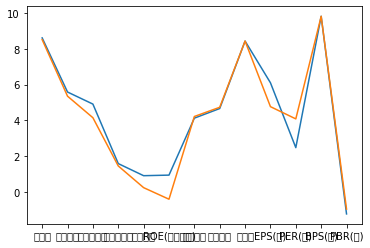

In [55]:
plt.plot(log_fs_df_2019.iloc[0,:])
plt.plot(log_fs_df_2020.iloc[0,:])
log_corr_df = pd.DataFrame()
for k in range(len(log_fs_df_2019.index)):
    x = log_fs_df_2019.iloc[k,:]
    y = log_fs_df_2020.iloc[k,:]
    correlation = np.corrcoef(x, y)[1][0]
    correlation = pd.Series(correlation)
    log_corr_df = pd.concat([log_corr_df,correlation])
    
log_corr_df.index = fs_df_2019.index

확실히 log변환을 하니 분포가 더 잘 보인다.  아래는 2020과 2019의 재무제표 간의 상관계수 값들을 box플롯으로 나타낸것이다. 많은 값들이 상관계수 1근처에 포진해있는 것으로 보아 두 데이터셋은 연관성이 있다고 판단한다.

<AxesSubplot:>

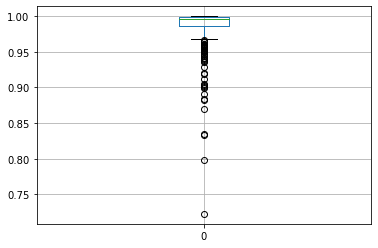

In [56]:
log_corr_df.boxplot()

In [57]:
print(log_fs_df_2019.isna().sum())
print(log_fs_df_2020.isna().sum())

매출액            0
영업이익         112
당기순이익        173
영업이익률        112
순이익률         173
ROE(지배주주)    175
부채비율           0
당좌비율           0
유보율           13
EPS(원)       174
PER(배)       174
BPS(원)         0
PBR(배)         0
dtype: int64
매출액            0
영업이익         133
당기순이익        186
영업이익률        133
순이익률         186
ROE(지배주주)    189
부채비율           2
당좌비율           0
유보율           18
EPS(원)       189
PER(배)       189
BPS(원)         1
PBR(배)         1
dtype: int64


결측치 값이 너무 많다. 아마 음수의 영향인것 같다. 
방법은 두가지 이다
1. 이대로 많은 데이터에 많은 손실이 있는 상태로 분석을진행한다.
2. 로그 변환의 일반화인 여존스 변환을 사용해본다. 

In [58]:
log_corr_df.isna().sum()

0    285
dtype: int64

In [59]:
from sklearn.preprocessing import power_transform
power_2020 = power_transform(fs_df_2020.iloc[0,:][:,np.newaxis])
power_2019 = power_transform(fs_df_2019.iloc[0,:][:,np.newaxis])

컬럼으로 람다를 설정하길레 transformation을 해주었다. 

In [60]:
import numpy as np
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
pt.fit(fs_df_2020.T)
PowerTransformer()
power_2020 = pt.transform(fs_df_2020.T)
pt_2 = PowerTransformer()
pt_2.fit(fs_df_2019.T)
PowerTransformer()
power_2019 = pt_2.transform(fs_df_2019.T)

In [61]:
power_2019 = power_2019.T
power_2020 = power_2020.T

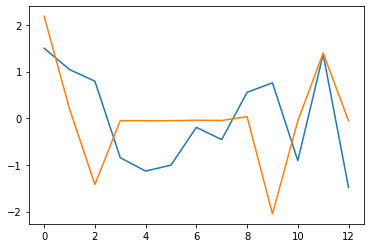

In [62]:
plt.plot(power_2019[2])
plt.plot(power_2020[2])

In [63]:
power_corr_df = pd.DataFrame()
for k in range(len(log_fs_df_2019.index)):
    x = power_2019[k]
    y = power_2020[k]
    correlation = np.corrcoef(x, y)[1][0]
    correlation = pd.Series(correlation)
    power_corr_df = pd.concat([power_corr_df,correlation])
power_corr_df.index = range(len(power_corr_df))

{'whiskers': [<matplotlib.lines.Line2D at 0x1fe0711e070>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe0711e610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe0710fd60>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe0711ebb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe0711ee80>],
 'means': []}

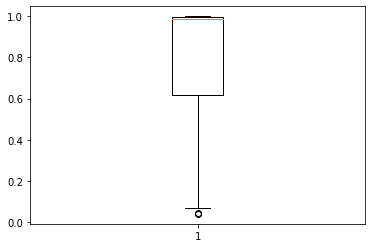

In [64]:
plt.boxplot(power_corr_df)

In [65]:
power_corr_df.describe()

,0
count,649.000000
mean,0.816240
std,0.278372
min,0.040472
25%,0.619697
50%,0.986228
75%,0.997252
max,0.999975


<AxesSubplot:ylabel='Density'>

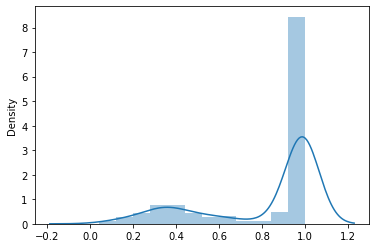

In [66]:
sns.distplot(power_corr_df)

In [67]:
power_corr_df.index = fs_df_2019.index

로그분포와 비교했을때 box플롯이 차이가 너무 난다. 두 데이터 프레임을 합쳐서 비교해보았더니 기존 로그값이 nan이였던 기업은 여존슨변환을 했을때 상관계수가 낮게 나오는 경향이 있는것 같았다.

In [68]:
df_concat = pd.concat([power_corr_df,log_corr_df],axis = 1)
df_concat

,0,0
004840,0.974630,0.975335
155660,0.999528,0.999545
078930,0.234732,NaN
294870,0.992366,0.991928
001390,0.983253,0.979769
...,...,...
010620,0.298945,NaN
011210,0.999590,0.999505
011760,0.982336,0.979722
227840,0.986975,0.988808


NaN이 있는 값들이 낮게 나온것 같다. 진짜일까?

NaN값만 뽑아와서 boxplot을 그려보았다.

<AxesSubplot:>

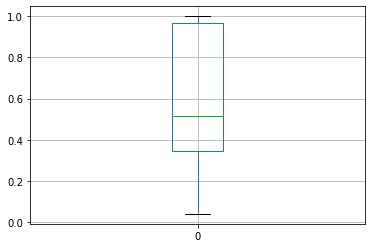

In [69]:
nan_df = pd.DataFrame(power_corr_df[log_corr_df[0].isna()][0])
nan_df.boxplot()

<AxesSubplot:>

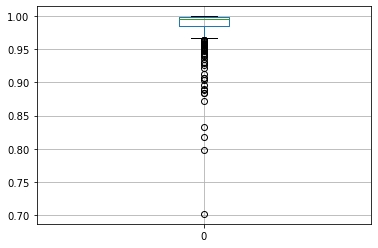

In [70]:
notnan_df = pd.DataFrame(power_corr_df[log_corr_df[0].notna()][0])
notnan_df.boxplot()

In [71]:
nan_df.describe()

,0
count,285.000000
mean,0.601412
std,0.305063
min,0.040472
25%,0.343462
50%,0.515169
75%,0.969039
max,0.999975


몇몇 이상치를 제외하고 기존 로그변환 값보다 낮게 나온것을 볼 수있다. 

이유를 찾기위해 람다 성정기준을 찾아보았지만 나오지 않았다

이유를 못찾겠다. 일단 기존 NaN값이였던 row의 값이 비정상적으로 낮은 값에 위치함을 알 수있다.
그럼으로 일단 로그분포에서 nan값은 제외한체 분석을 계속 진행한다.

In [72]:
log_corr_df.dropna(inplace = True)

In [73]:
log_corr_df.describe()

,0
count,364.000000
mean,0.984730
std,0.029478
min,0.722657
25%,0.985566
50%,0.995528
75%,0.998307
max,0.999893


<AxesSubplot:ylabel='Density'>

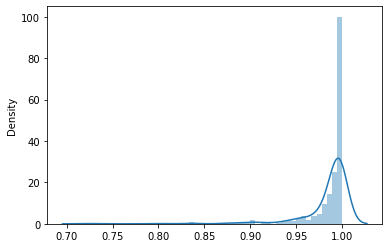

In [74]:
sns.distplot(log_corr_df)

### 대부분의 값들이 0.8 ~ 1.0에 분포함을 알 수있다.
현재 분석한 데이터는 기업들의 2019 재무제표와 2020재무제표를 상관관계 분석을 한것이다.
상관계수가 높은 것을 보아 우리는 한 기업 내에서 2019년도 재무제표와 2020년도의 재무제표가 서로 유사한 형태의 그래프임을 알 수있다. 이는 재무제표속 값들속 상대적 비율이 일정하게 유지 되면서 값들이 움직인다고 볼 수있다. 
위 분석의 결과를 통해 다른 기업과 재무제표를 비교하는게 의미가 있다는 것을 알 수있다. 
### 다시 가설2 로 돌아와서 제무제표의 상관계수를 통해 기업의 pair를 찾아보자

### 데이터는 2020데이터를 사용한다.

In [75]:
fs_df_2020_log = np.log(fs_df_2020)

In [76]:
fs_df_2020_log.isna().sum()

매출액            0
영업이익         133
당기순이익        186
영업이익률        133
순이익률         186
ROE(지배주주)    189
부채비율           2
당좌비율           0
유보율           18
EPS(원)       189
PER(배)       189
BPS(원)         1
PBR(배)         1
dtype: int64

여기에서도 log변환을 사용했기에 0은 결측치로 대체 되었다. 
원계획은 여존슨 변환으로 한번 더 분석 할 예정이였지만 주제1에서 변환을 했을때 데이터가 극단적으로 버러지는 것을 보고 그냥 결측치를 삭제하는 방향으로 진행하였다.

In [77]:
fs_df_2020_log.dropna(inplace = True)

In [78]:
len(fs_df_2020_log.index)

437

In [79]:
fs_df_2020_log.T.corr()

,004840,155660,294870,001390,025000,044450,058860,011070,023150,178920,...,103140,004090,002960,000970,016450,010420,005440,011210,011760,227840
004840,1.000000,0.957660,0.868326,0.862971,0.858631,0.942740,0.963232,0.887182,0.888887,0.925266,...,0.914912,0.965973,0.844379,0.935465,0.888929,0.931207,0.940800,0.951443,0.871899,0.860789
155660,0.957660,1.000000,0.927149,0.930105,0.956425,0.965617,0.981736,0.939024,0.948573,0.978812,...,0.965083,0.991558,0.942868,0.988423,0.952996,0.950895,0.970549,0.971712,0.950031,0.951536
294870,0.868326,0.927149,1.000000,0.991993,0.950185,0.922701,0.919783,0.983717,0.870684,0.953219,...,0.986061,0.911122,0.898638,0.946501,0.967378,0.874086,0.964889,0.952111,0.952211,0.921806
001390,0.862971,0.930105,0.991993,1.000000,0.942050,0.926456,0.928106,0.991214,0.888247,0.943667,...,0.990128,0.917914,0.899825,0.945727,0.982759,0.895714,0.966293,0.961991,0.974066,0.911788
025000,0.858631,0.956425,0.950185,0.942050,1.000000,0.903793,0.915613,0.945160,0.887570,0.980256,...,0.962662,0.921663,0.979329,0.971073,0.932989,0.866037,0.942323,0.933611,0.938273,0.984593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
010420,0.931207,0.950895,0.874086,0.895714,0.866037,0.904663,0.986238,0.895582,0.906475,0.886476,...,0.919973,0.969532,0.862398,0.941293,0.931242,1.000000,0.928079,0.959500,0.954881,0.886044
005440,0.940800,0.970549,0.964889,0.966293,0.942323,0.938858,0.972192,0.974202,0.882816,0.975829,...,0.984362,0.963196,0.894576,0.984531,0.981667,0.928079,1.000000,0.983551,0.957162,0.919385
011210,0.951443,0.971712,0.952111,0.961991,0.933611,0.939412,0.983060,0.974263,0.900937,0.959166,...,0.984902,0.969287,0.916116,0.976556,0.968743,0.959500,0.983551,1.000000,0.971135,0.924401
011760,0.871899,0.950031,0.952211,0.974066,0.938273,0.912093,0.961495,0.965314,0.908268,0.930662,...,0.972892,0.947035,0.918344,0.960915,0.982511,0.954881,0.957162,0.971135,1.000000,0.929858


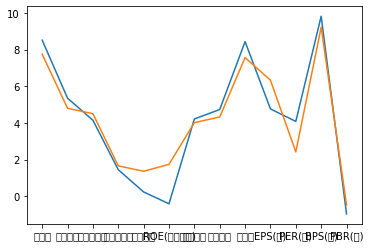

In [80]:
plt.plot(fs_df_2020_log.iloc[0,:])
plt.plot(fs_df_2020_log.iloc[1,:])

In [81]:
df = pd.read_csv('all_data_set.csv') 

In [82]:
df_T = df.T

In [83]:
for i in df_T.index:
    if i not in intersection_index:
        df_T.drop(i, inplace = True)


In [84]:
df = df_T.T

In [85]:
df

,000210,004840,155660,078930,294870,001390,025000,044450,058860,011070,...,010420,014130,005110,005440,064350,010620,011210,011760,227840,010690
0,68800.0,4180.0,6370.0,47250.0,11100.0,23400.0,48700.0,9550.0,2480.0,302000.0,...,1790.0,5160.0,843.0,6910.0,29900.0,91000.0,60200.0,17650.0,11150.0,8880.0
1,66500.0,4180.0,6260.0,47050.0,11000.0,22950.0,48400.0,9540.0,2440.0,303000.0,...,1760.0,5090.0,847.0,6840.0,28850.0,90200.0,59000.0,17300.0,11000.0,8550.0
2,64600.0,4230.0,6310.0,47150.0,10850.0,23350.0,48450.0,9550.0,2435.0,308500.0,...,1765.0,5060.0,845.0,6860.0,29150.0,90200.0,60000.0,17100.0,11150.0,8780.0
3,64700.0,4280.0,6070.0,46300.0,11200.0,23850.0,49100.0,9690.0,2490.0,307500.0,...,1835.0,4955.0,858.0,6950.0,27350.0,91000.0,60500.0,17450.0,11250.0,9210.0
4,64700.0,4265.0,6040.0,46450.0,11350.0,24450.0,49450.0,9900.0,2525.0,310500.0,...,1815.0,4985.0,869.0,6950.0,28050.0,90800.0,60500.0,17500.0,11350.0,9330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
dict(df_T.T.isna().sum().value_counts())

{5: 246,
 32: 67,
 1185: 11,
 181: 5,
 5559: 4,
 376: 4,
 582: 4,
 7: 4,
 62: 3,
 5415: 3,
 3597: 3,
 8: 3,
 155: 3,
 5271: 3,
 3472: 2,
 4151: 2,
 892: 2,
 1245: 2,
 39: 2,
 4874: 2,
 12: 2,
 580: 2,
 35: 2,
 1300: 2,
 585: 2,
 2107: 2,
 449: 2,
 343: 2,
 15: 2,
 1278: 2,
 583: 2,
 3547: 1,
 1157: 1,
 1058: 1,
 2045: 1,
 5273: 1,
 1496: 1,
 5140: 1,
 1011: 1,
 5235: 1,
 3606: 1,
 2348: 1,
 1180: 1,
 4539: 1,
 3933: 1,
 5614: 1,
 2602: 1,
 3720: 1,
 2912: 1,
 5881: 1,
 4512: 1,
 1500: 1,
 4660: 1,
 2431: 1,
 3636: 1,
 3486: 1,
 3824: 1,
 3072: 1,
 5408: 1,
 5432: 1,
 885: 1,
 4409: 1,
 5648: 1,
 3681: 1,
 3468: 1,
 267: 1,
 3096: 1,
 523: 1,
 2444: 1,
 3559: 1,
 1690: 1,
 982: 1,
 5412: 1,
 765: 1,
 2098: 1,
 4594: 1,
 5436: 1,
 2887: 1,
 5254: 1,
 3825: 1,
 4708: 1,
 5886: 1,
 5056: 1,
 2415: 1,
 5572: 1,
 4377: 1,
 2563: 1,
 5603: 1,
 4632: 1,
 1671: 1,
 2408: 1,
 4905: 1,
 2364: 1,
 2331: 1,
 5081: 1,
 5720: 1,
 2486: 1,
 5386: 1,
 3239: 1,
 4684: 1,
 1446: 1,
 1013: 1,
 2809: 1,
 3

코스피에 상장한 모든 기업의 가격데이터를 들고왔다. 먼저 intersection_index와 일치하는 기업만 들고온다. 이후 결측치를 확인해보았더니 다양하다 아마 상장 날짜가 제각기 다르기 때문일 것이다. 결측치 처리를 해야하는데 여기서 방법이 두가지가 있다.
#### 1. 일정 비율이상 결측치를 가지는 기업을 삭제하고 나머지는 날짜를 기준으로 결측치를 삭제한다
#### 2. 위 dict에서 보이는 것 처럼 결측치가 5개인 기업이 245개 임으로 이 기업만 가지고 분석을 진행한다.

In [87]:
new_df = df.loc[:,df.isna().sum() == 5].dropna(axis = 0)

In [88]:
import pickle
with open('pairs.pickle', 'rb') as fid:

    pairs = pickle.load(fid,encoding='utf-8')

공적분을 활용해 pair를 tuple형태로 저장하였다. 아래 코드는 pair들을 dict형태로 저장한것이다.

In [89]:
one_pair_list = []
two_pair_list = []
pair_dic = dict()
count = 0
for i in range(len(pairs)):
    a,b = pairs[i]
    
    
    
    if i > 0 & i != (len(pairs)-1):
        if a in one_pair_list: #key값이 같은 데이터가 들어왔음
            two_pair_list.append(b)
        else:
            one_pair_list.append(a)#key값이 달라짐 
            pair_dic[one_pair_list[count]] = list(two_pair_list)
            two_pair_list.clear()
            two_pair_list.append(b)
            count += 1
            
    else:
        one_pair_list.append(a)
        two_pair_list.append(b)
            
    if i == (len(pairs)-1):
        pair_dic[one_pair_list[count]] = list(two_pair_list)
        two_pair_list.clear()
        two_pair_list.append(b)
        pair_dic[one_pair_list[count]] = list(two_pair_list)
        print('end')
        

            



end


In [90]:
a = np.log(fs_df_2019).T.corr()

In [91]:
count_0 = 0
new_list_2 =[]
new_list_3 = []
for i in one_pair_list:
    df_pair_1 = pd.DataFrame(a.loc[i])
    df_pair_1 = df_pair_1.sort_values(by = i)
    df_pair_1.index = range(len(df_pair_1))
    for k in pair_dic[one_pair_list[count_0]]:
        count = 0
        for j in pd.DataFrame(a.loc[i]).iloc[:,0]: #log변환 한 재무제표의 각기업을 들고옴
            if float(j) == a.loc[i,k]: #ex) float(j) == 0.9166428579406288
                new_list_3.append(f'{count}/{len(fs_df_2019)}')
            count += 1
       
    count_0 += 1
    new_list_2.append(list(new_list_3))
    new_list_3.clear()



위 코드는 pair들로 짝지어진 기업들의 상관계수가 전체 상관계수 값에서 어느정도 위치하는지 비율로 나타낸것이다. 비율들이 다 제각각 분포해있음을 알 수있다. 


In [92]:
new_ratio_list = []
for k in range(len(new_list_2)):
    for i in new_list_2[k]:
        a,b = i.split('/')
        a = int(a)
        b = int(b)
        new_ratio_list.append(1 - a/b)
        
new_ratio_ary = np.array(new_ratio_list)

new_ratio_list에 있는 값들이 1에 가까울 수록 pair들로 짝지어진 기업들의 상관계수값이 상위에 있다.

<AxesSubplot:>

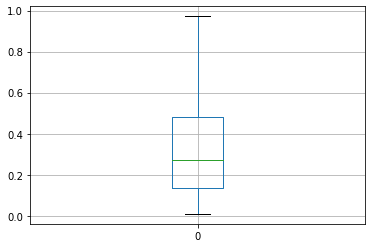

In [93]:
pd.DataFrame(new_ratio_ary).boxplot()

<AxesSubplot:ylabel='Density'>

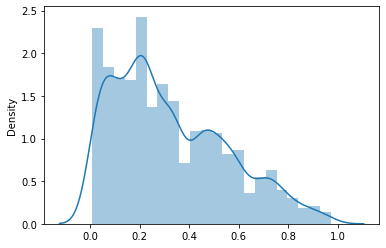

In [94]:
sns.distplot(new_ratio_ary)

## 주제2 결론 : 재무제표는 주가랑 높은 연관관계가 없다.

# 전체 분석의 한계점
먼저 데이터 상관관계 분석을 진행할때 피어슨상관계수만 쓴 점
마할노비스 거리를 이용한 클러스터링을 진행하려고 하였지만 시간상 기각
회기분석또한 진행해볼 생각이였지만 시간상 기각
이후 다른여러가지 분석방법이 있었지만 생각보다 크롤링과 전처리에 시간을 많이 사용하여 시도해보지 못하였다. 
그리고 분석을 진행한 후 결과를 내고 다른 연구들을 보고 따라해 비교해볼 생각이였지만 시간 그리고 딱 맞는 논문이 많지 않아 해보지 못하였다. 

## 이후 해보고싶은것
이번 경희대에서 열리는 창업공모전에 나가게 되었는데 창업아이템으로 saas를 활용한 문서,필기 웹을 만들어볼 생각이다. 이때 클라우드 서비스 관련 데이터들이 공공데이터로 올라와있어 시장조사를 할 때 상용해볼 생각이다

금융관련으로는 투자자심리에 대한 분석을 진행해보고 싶다.

### 아래 코드는 크롤링 코드중 데이터 크기가 큰 코드와 공적분을 이용해 pair를 짝었을때 사용한 코드이다.

In [95]:
headers=('User-Agent','Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36') 
url='https://finance.naver.com/item/sise_day.nhn?code=000100' # 000100= 유한양행 종목코드


opener = req.build_opener()
opener.addheaders = [headers]
response=opener.open(url)
doc=bs(response,'lxml')     
last_page = doc.find('td',class_='pgRR').a['href'].split('=')[-1]
print('총페이지 : '+last_page)


df=pd.DataFrame()
for page in range(1,int(last_page)+1):
    page_url='{}&page={}'.format(url,page)
    response=opener.open(page_url)
    df=pd.concat([df,pd.read_html(response,header=0)[0]])

df = df.dropna()
df.index = range(0,len(df.index))
df

총페이지 : 664


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import requests
fs_df_2019 = pd.DataFrame()
for code in new_code_list:
    
    URL = f"https://finance.naver.com/item/main.nhn?code={code}"
    r = requests.get(URL)
    df_1 = pd.read_html(r.text)[3]
    df_1.set_index(df_1.columns[0],inplace=True)
    df_1.index.rename('주요재무정보', inplace=True)
    
    df_2 = pd.DataFrame(df_1.T.iloc[0,:]).T
    fs_df_2019 = pd.concat([fs_df_2019,df_2])

fs_df_2019.index = new_code_list
fs_df_2019.columns.rename(('종목코드','2019'), inplace=True)
fs_df_2019

In [ ]:
import pandas as pd
import requests
new_df_2_2 = pd.DataFrame()
list_0 = []
for code in new_code_list:
    try:
        URL = f"https://finance.naver.com/item/main.nhn?code={code}"
        r = requests.get(URL)
        df_1_2 = pd.read_html(r.text)[3]
        df_1_2.set_index(df_1_2.columns[0],inplace=True)
        df_1_2.index.rename('주요재무정보', inplace=True)

        df_2_2 = pd.DataFrame(df_1_2.T.iloc[1,:]).T
        new_df_2_2 = pd.concat([new_df_2_2,df_2_2])
    except:
        list_0.append(code)
new_code_list_2 = new_code_list
for k in list_0:
    new_code_list_2.remove(k)
    
    
    
new_df_2_2.index = new_code_list_2
new_df_2_2.columns.rename(('종목코드','2020'), inplace=True)
new_df_2_2

In [ ]:
#전체 가격데이터
import pandas as pd
from urllib import request as req
from bs4 import BeautifulSoup as bs

df = pd.DataFrame()
for i in new_code_list:
    headers=('User-Agent','Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36') 
    url=f'https://finance.naver.com/item/sise_day.nhn?code={i}' #너무 오래걸려서 슬라이싱 컴퓨터로 다시해봐야 할듯 하다가 자꾸 노트북이 다운됨

    df_1=pd.DataFrame()
    opener = req.build_opener()
    opener.addheaders = [headers]
    response=opener.open(url)
    doc=bs(response,'lxml')
    last_page = doc.find('td',class_='pgRR').a['href'].split('=')[-1]
    print('총페이지 : '+last_page)
    for page in range(1,int(last_page) + 1):
        page_url='{}&page={}'.format(url,page)
        response=opener.open(page_url)
        df_1=pd.concat([df_1,pd.read_html(response,header=0)[0]])

    df_1 = df_1.dropna()
    date_list = list(df_1['날짜'])
    df_1.index = date_list
    df_1.drop('날짜',axis = 1,inplace = True)
    df_1 = pd.DataFrame(df_1['종가'])
    df_1.rename(columns = {'종가':f'{i}'},inplace = True)
    df = pd.concat([df,df_1],axis = 1)

In [ ]:
#공적분을 활용한 pair트레이딩 
#공적분을 활용해서 pair를 찾는과정 
def find_cointegrated_pairs(new_df):
    n = new_df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = new_df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = new_df[keys[i]]
            S2 = new_df[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(new_df)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, 
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)